# Analysis correlation among municipal attributes and mortality rate
## Workflow: execute after 06_risk_factor_measures

In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from datetime import  timedelta

import util
import matplotlib.dates as mdates

## Loading data

In [33]:
ts_covid = pd.read_csv('../covid/data/output/df_sim_covid_deaths_municipal_timeseries.csv')
ts_covid.DATA = pd.to_datetime(ts_covid.DATA, infer_datetime_format=True)
ts_covid.CODIGO_MUNICIPIO_6 = ts_covid.CODIGO_MUNICIPIO_6.astype('Int64')
ts_covid = ts_covid.sort_values('DATA')
ts_covid

,DATA,CODIGO_MUNICIPIO_6,OBITOS_NOVOS,OBITOS,MUNICIPIO,SIGLA_ESTADO,ESTADO,REGIAO,POPULACAO_2022,TAXA_OBITOS_NOVOS,TAXA_OBITOS
0,2020-03-12,355030,1,1,São Paulo,SP,São Paulo,Sudeste,11451245.0,0.008733,0.008733
3725,2020-03-12,421510,0,0,Rodeio,SC,Santa Catarina,Sul,12757.0,0.000000,0.000000
3724,2020-03-12,150085,0,0,Anapu,PA,Pará,Norte,31850.0,0.000000,0.000000
3723,2020-03-12,431171,0,0,Maçambará,RS,Rio Grande do Sul,Sul,4425.0,0.000000,0.000000
3722,2020-03-12,431805,0,0,São Domingos do Sul,RS,Rio Grande do Sul,Sul,2754.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5716800,2022-12-31,312870,0,191,Guaxupé,MG,Minas Gerais,Sudeste,50911.0,0.000000,375.164503
5716799,2022-12-31,313867,0,22,Luisburgo,MG,Minas Gerais,Sudeste,6956.0,0.000000,316.273721
5716798,2022-12-31,432195,0,20,Trindade do Sul,RS,Rio Grande do Sul,Sul,7556.0,0.000000,264.690312
5716806,2022-12-31,432100,0,51,Tapera,RS,Rio Grande do Sul,Sul,10592.0,0.000000,481.495468


In [34]:
df_base = pd.read_csv('data/df_labeled_risk_factors.csv')
df_base.CODIGO_MUNICIPIO_6 = df_base.CODIGO_MUNICIPIO_6.astype('Int64')
df_base

,Unnamed: 0,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
0,5569,530010,DF,53,Centro-Oeste,DISTRITO FEDERAL,53001.0,1.0,Distrito Federal,5300108,...,0,High,1,Intermediate,5,Low,0.493688,-0.235839,2,Very low SV
1,3848,355220,SP,35,Sudeste,SOROCABA,35163.0,0.0,São Paulo,3552205,...,2,Intermediate,3,Very high,0,High,0.554712,-0.250728,2,Very low SV
2,3849,355230,SP,35,Sudeste,LAGOS DO DRS II,35022.0,0.0,São Paulo,3552304,...,1,Low,1,Intermediate,5,Low,0.489724,-0.070913,2,Very low SV
3,3850,355240,SP,35,Sudeste,REGIAO METROPOLITANA DE CAMPINAS,35072.0,1.0,São Paulo,3552403,...,0,High,2,High,2,Intermediate,0.515029,-0.254067,2,Very low SV
4,3851,355250,SP,35,Sudeste,ALTO DO TIETE,35011.0,1.0,São Paulo,3552502,...,0,High,2,High,5,Low,0.407419,-0.244740,2,Very low SV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,1395,251240,PB,25,Nordeste,16ª REGIAO,25016.0,0.0,Paraíba,2512408,...,1,Low,0,Very low,1,Very low,-0.371442,0.076947,3,Very high SV
5561,4047,410950,PR,41,Sul,1ª RS PARANAGUA,41001.0,0.0,Paraná,4109500,...,2,Intermediate,1,Intermediate,1,Very low,-0.470157,0.006578,3,Very high SV
5562,1397,251260,PB,25,Nordeste,6ª REGIAO,25006.0,0.0,Paraíba,2512606,...,5,Very low,0,Very low,1,Very low,-0.485774,-0.025340,3,Very high SV
5563,1432,251460,PB,25,Nordeste,6ª REGIAO,25006.0,0.0,Paraíba,2514602,...,0,High,4,Low,1,Very low,-0.450844,-0.042866,3,Very high SV


In [35]:
df_dates = ts_covid[['DATA']].drop_duplicates()

In [36]:
df_dates

,DATA
0,2020-03-12
9299,2020-03-13
14881,2020-03-14
20467,2020-03-15
26044,2020-03-16
...,...
5696338,2022-12-27
5701920,2022-12-28
5707500,2022-12-29
5713083,2022-12-30


In [37]:
df_base.groupby('REGIAO')[['PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'GINI']].median()

,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS,GINI
REGIAO,,,
Centro-Oeste,17.355,10.525,0.49
Nordeste,19.275,11.415,0.52
Norte,19.700,7.620,0.56
Sudeste,17.010,13.080,0.46
Sul,16.590,13.835,0.46


In [38]:
correlation, pvalue = spearmanr(df_base[['PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'GINI']].dropna())

In [39]:
correlation

-0.3537447956405515

In [40]:
round(pvalue,4)

0.0

In [41]:
df_base

,Unnamed: 0,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
0,5569,530010,DF,53,Centro-Oeste,DISTRITO FEDERAL,53001.0,1.0,Distrito Federal,5300108,...,0,High,1,Intermediate,5,Low,0.493688,-0.235839,2,Very low SV
1,3848,355220,SP,35,Sudeste,SOROCABA,35163.0,0.0,São Paulo,3552205,...,2,Intermediate,3,Very high,0,High,0.554712,-0.250728,2,Very low SV
2,3849,355230,SP,35,Sudeste,LAGOS DO DRS II,35022.0,0.0,São Paulo,3552304,...,1,Low,1,Intermediate,5,Low,0.489724,-0.070913,2,Very low SV
3,3850,355240,SP,35,Sudeste,REGIAO METROPOLITANA DE CAMPINAS,35072.0,1.0,São Paulo,3552403,...,0,High,2,High,2,Intermediate,0.515029,-0.254067,2,Very low SV
4,3851,355250,SP,35,Sudeste,ALTO DO TIETE,35011.0,1.0,São Paulo,3552502,...,0,High,2,High,5,Low,0.407419,-0.244740,2,Very low SV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,1395,251240,PB,25,Nordeste,16ª REGIAO,25016.0,0.0,Paraíba,2512408,...,1,Low,0,Very low,1,Very low,-0.371442,0.076947,3,Very high SV
5561,4047,410950,PR,41,Sul,1ª RS PARANAGUA,41001.0,0.0,Paraná,4109500,...,2,Intermediate,1,Intermediate,1,Very low,-0.470157,0.006578,3,Very high SV
5562,1397,251260,PB,25,Nordeste,6ª REGIAO,25006.0,0.0,Paraíba,2512606,...,5,Very low,0,Very low,1,Very low,-0.485774,-0.025340,3,Very high SV
5563,1432,251460,PB,25,Nordeste,6ª REGIAO,25006.0,0.0,Paraíba,2514602,...,0,High,4,Low,1,Very low,-0.450844,-0.042866,3,Very high SV


In [42]:
df_base

,Unnamed: 0,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,ESTADO,CODIGO_MUNICIPIO_7,...,NIVEL_TAXA_OBITOS_2020,NIVEL_LABEL_TAXA_OBITOS_2020,NIVEL_TAXA_OBITOS_2021,NIVEL_LABEL_TAXA_OBITOS_2021,NIVEL_TAXA_OBITOS_2022,NIVEL_LABEL_TAXA_OBITOS_2022,componente_principal_1,componente_principal_2,k5,k5_label
0,5569,530010,DF,53,Centro-Oeste,DISTRITO FEDERAL,53001.0,1.0,Distrito Federal,5300108,...,0,High,1,Intermediate,5,Low,0.493688,-0.235839,2,Very low SV
1,3848,355220,SP,35,Sudeste,SOROCABA,35163.0,0.0,São Paulo,3552205,...,2,Intermediate,3,Very high,0,High,0.554712,-0.250728,2,Very low SV
2,3849,355230,SP,35,Sudeste,LAGOS DO DRS II,35022.0,0.0,São Paulo,3552304,...,1,Low,1,Intermediate,5,Low,0.489724,-0.070913,2,Very low SV
3,3850,355240,SP,35,Sudeste,REGIAO METROPOLITANA DE CAMPINAS,35072.0,1.0,São Paulo,3552403,...,0,High,2,High,2,Intermediate,0.515029,-0.254067,2,Very low SV
4,3851,355250,SP,35,Sudeste,ALTO DO TIETE,35011.0,1.0,São Paulo,3552502,...,0,High,2,High,5,Low,0.407419,-0.244740,2,Very low SV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,1395,251240,PB,25,Nordeste,16ª REGIAO,25016.0,0.0,Paraíba,2512408,...,1,Low,0,Very low,1,Very low,-0.371442,0.076947,3,Very high SV
5561,4047,410950,PR,41,Sul,1ª RS PARANAGUA,41001.0,0.0,Paraná,4109500,...,2,Intermediate,1,Intermediate,1,Very low,-0.470157,0.006578,3,Very high SV
5562,1397,251260,PB,25,Nordeste,6ª REGIAO,25006.0,0.0,Paraíba,2512606,...,5,Very low,0,Very low,1,Very low,-0.485774,-0.025340,3,Very high SV
5563,1432,251460,PB,25,Nordeste,6ª REGIAO,25006.0,0.0,Paraíba,2514602,...,0,High,4,Low,1,Very low,-0.450844,-0.042866,3,Very high SV


In [43]:
df_base['KEY'] = 0
df_dates['KEY'] = 0
df_cross_dates_base = df_dates.merge(df_base[['KEY','CODIGO_MUNICIPIO_6', 'REGIAO_EN', 'k5_label', 'SIGLA_ESTADO', 'PERCENTUAL_POPULACAO_0_A_5_ANOS', 'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS', 'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'PERCENTUAL_POPULACAO_URBANA', 'IDHM_RENDA', 'GINI', 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'TAXA_ATIVIDADE', 'PERCENTUAL_TRABALHADORES_INFORMAIS', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO', 'PERCENTUAL_OCUPADOS_SERVICO', 'PERCENTUAL_OCUPADOS_INDUSTRIA', 'POPULACAO_2022']], how='outer')
df_cross_dates_base

,DATA,KEY,CODIGO_MUNICIPIO_6,REGIAO_EN,k5_label,SIGLA_ESTADO,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,...,IDHM_RENDA,GINI,TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,POPULACAO_2022
0,2020-03-12,0,530010,Midwestern,Very low SV,DF,8.90,14.78,18.15,28.56,...,0.863,0.63,32.04,64.58,28.38,1.84,14.55,62.48,4.25,2817068
1,2020-03-12,0,355220,Southeast,Very low SV,SP,7.52,13.54,17.21,25.88,...,0.792,0.52,23.57,60.02,26.75,0.80,15.87,45.40,21.75,723574
2,2020-03-12,0,355230,Southeast,Very low SV,SP,7.88,13.56,16.99,24.87,...,0.743,0.54,30.07,59.68,27.05,28.14,6.44,33.84,20.58,7355
3,2020-03-12,0,355240,Southeast,Very low SV,SP,8.68,14.26,17.96,27.42,...,0.744,0.45,30.26,62.30,24.60,1.61,15.91,42.06,19.77,279546
4,2020-03-12,0,355250,Southeast,Very low SV,SP,8.71,16.19,17.78,25.19,...,0.708,0.47,46.21,58.06,32.93,2.80,16.77,44.10,20.51,307364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704120,2022-12-31,0,251240,Northeast,Very high SV,PB,10.49,16.80,18.83,22.36,...,0.574,0.45,202.02,58.94,70.89,48.97,10.25,26.32,5.68,14277
5704121,2022-12-31,0,410950,South,Very high SV,PR,9.53,18.60,17.34,22.09,...,0.587,0.49,266.19,53.82,46.74,58.48,3.89,26.89,2.36,7430
5704122,2022-12-31,0,251260,Northeast,Very high SV,PB,9.77,16.89,19.54,23.37,...,0.564,0.46,300.63,53.36,75.66,39.59,7.65,29.88,4.22,1743
5704123,2022-12-31,0,251460,Northeast,Very high SV,PB,9.87,16.58,18.37,23.29,...,0.549,0.48,254.20,40.47,73.57,32.34,9.30,36.61,2.39,3242


In [44]:
len(df_cross_dates_base.DATA.unique())

1025

In [45]:
ts_covid['TAXA_OBITOS_NOVOS'] = ts_covid.OBITOS / ts_covid.POPULACAO_2022 * 100000

In [46]:
ts = df_cross_dates_base.merge(ts_covid[['DATA', 'CODIGO_MUNICIPIO_6', 'OBITOS_NOVOS', 'OBITOS']], how='left', left_on=['DATA', 'CODIGO_MUNICIPIO_6'], right_on=['DATA', 'CODIGO_MUNICIPIO_6'])
ts

,DATA,KEY,CODIGO_MUNICIPIO_6,REGIAO_EN,k5_label,SIGLA_ESTADO,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,...,TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,POPULACAO_2022,OBITOS_NOVOS,OBITOS
0,2020-03-12,0,530010,Midwestern,Very low SV,DF,8.90,14.78,18.15,28.56,...,32.04,64.58,28.38,1.84,14.55,62.48,4.25,2817068,0.0,0.0
1,2020-03-12,0,355220,Southeast,Very low SV,SP,7.52,13.54,17.21,25.88,...,23.57,60.02,26.75,0.80,15.87,45.40,21.75,723574,0.0,0.0
2,2020-03-12,0,355230,Southeast,Very low SV,SP,7.88,13.56,16.99,24.87,...,30.07,59.68,27.05,28.14,6.44,33.84,20.58,7355,0.0,0.0
3,2020-03-12,0,355240,Southeast,Very low SV,SP,8.68,14.26,17.96,27.42,...,30.26,62.30,24.60,1.61,15.91,42.06,19.77,279546,0.0,0.0
4,2020-03-12,0,355250,Southeast,Very low SV,SP,8.71,16.19,17.78,25.19,...,46.21,58.06,32.93,2.80,16.77,44.10,20.51,307364,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704120,2022-12-31,0,251240,Northeast,Very high SV,PB,10.49,16.80,18.83,22.36,...,202.02,58.94,70.89,48.97,10.25,26.32,5.68,14277,0.0,16.0
5704121,2022-12-31,0,410950,South,Very high SV,PR,9.53,18.60,17.34,22.09,...,266.19,53.82,46.74,58.48,3.89,26.89,2.36,7430,0.0,18.0
5704122,2022-12-31,0,251260,Northeast,Very high SV,PB,9.77,16.89,19.54,23.37,...,300.63,53.36,75.66,39.59,7.65,29.88,4.22,1743,NaN,NaN
5704123,2022-12-31,0,251460,Northeast,Very high SV,PB,9.87,16.58,18.37,23.29,...,254.20,40.47,73.57,32.34,9.30,36.61,2.39,3242,0.0,7.0


In [47]:
ts.OBITOS = ts.OBITOS.fillna(0)
ts.OBITOS_NOVOS = ts.OBITOS_NOVOS.fillna(0)

In [48]:
ts = ts.dropna().copy()

In [49]:
ts.isna().any()

DATA                                    False
KEY                                     False
CODIGO_MUNICIPIO_6                      False
REGIAO_EN                               False
k5_label                                False
SIGLA_ESTADO                            False
PERCENTUAL_POPULACAO_0_A_5_ANOS         False
PERCENTUAL_POPULACAO_6_A_14_ANOS        False
PERCENTUAL_POPULACAO_15_A_24_ANOS       False
PERCENTUAL_POPULACAO_25_A_39_ANOS       False
PERCENTUAL_POPULACAO_40_A_59_ANOS       False
PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS    False
PERCENTUAL_POPULACAO_URBANA             False
IDHM_RENDA                              False
GINI                                    False
TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA    False
TAXA_ATIVIDADE                          False
PERCENTUAL_TRABALHADORES_INFORMAIS      False
PERCENTUAL_OCUPADOS_AGROPECUARIA        False
PERCENTUAL_OCUPADOS_COMERCIO            False
PERCENTUAL_OCUPADOS_SERVICO             False
PERCENTUAL_OCUPADOS_INDUSTRIA     

In [50]:
len(ts.CODIGO_MUNICIPIO_6.unique())

5565

In [51]:
ts['TAXA_OBITOS_ACUMULADO'] = ts.OBITOS / ts.POPULACAO_2022 * 100000
ts

,DATA,KEY,CODIGO_MUNICIPIO_6,REGIAO_EN,k5_label,SIGLA_ESTADO,PERCENTUAL_POPULACAO_0_A_5_ANOS,PERCENTUAL_POPULACAO_6_A_14_ANOS,PERCENTUAL_POPULACAO_15_A_24_ANOS,PERCENTUAL_POPULACAO_25_A_39_ANOS,...,TAXA_ATIVIDADE,PERCENTUAL_TRABALHADORES_INFORMAIS,PERCENTUAL_OCUPADOS_AGROPECUARIA,PERCENTUAL_OCUPADOS_COMERCIO,PERCENTUAL_OCUPADOS_SERVICO,PERCENTUAL_OCUPADOS_INDUSTRIA,POPULACAO_2022,OBITOS_NOVOS,OBITOS,TAXA_OBITOS_ACUMULADO
0,2020-03-12,0,530010,Midwestern,Very low SV,DF,8.90,14.78,18.15,28.56,...,64.58,28.38,1.84,14.55,62.48,4.25,2817068,0.0,0.0,0.000000
1,2020-03-12,0,355220,Southeast,Very low SV,SP,7.52,13.54,17.21,25.88,...,60.02,26.75,0.80,15.87,45.40,21.75,723574,0.0,0.0,0.000000
2,2020-03-12,0,355230,Southeast,Very low SV,SP,7.88,13.56,16.99,24.87,...,59.68,27.05,28.14,6.44,33.84,20.58,7355,0.0,0.0,0.000000
3,2020-03-12,0,355240,Southeast,Very low SV,SP,8.68,14.26,17.96,27.42,...,62.30,24.60,1.61,15.91,42.06,19.77,279546,0.0,0.0,0.000000
4,2020-03-12,0,355250,Southeast,Very low SV,SP,8.71,16.19,17.78,25.19,...,58.06,32.93,2.80,16.77,44.10,20.51,307364,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704120,2022-12-31,0,251240,Northeast,Very high SV,PB,10.49,16.80,18.83,22.36,...,58.94,70.89,48.97,10.25,26.32,5.68,14277,0.0,16.0,112.068362
5704121,2022-12-31,0,410950,South,Very high SV,PR,9.53,18.60,17.34,22.09,...,53.82,46.74,58.48,3.89,26.89,2.36,7430,0.0,18.0,242.261104
5704122,2022-12-31,0,251260,Northeast,Very high SV,PB,9.77,16.89,19.54,23.37,...,53.36,75.66,39.59,7.65,29.88,4.22,1743,0.0,0.0,0.000000
5704123,2022-12-31,0,251460,Northeast,Very high SV,PB,9.87,16.58,18.37,23.29,...,40.47,73.57,32.34,9.30,36.61,2.39,3242,0.0,7.0,215.916101


In [52]:
selected_attributes = ['PERCENTUAL_POPULACAO_0_A_5_ANOS',
          'PERCENTUAL_POPULACAO_6_A_14_ANOS',
          'PERCENTUAL_POPULACAO_15_A_24_ANOS',
          'PERCENTUAL_POPULACAO_25_A_39_ANOS',
          'PERCENTUAL_POPULACAO_40_A_59_ANOS',
          'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS',
         'PERCENTUAL_POPULACAO_URBANA',
         'IDHM_RENDA',
          'GINI',
          'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA',
         'TAXA_ATIVIDADE',
                       'PERCENTUAL_TRABALHADORES_INFORMAIS',
                       'PERCENTUAL_OCUPADOS_AGROPECUARIA',
                       'PERCENTUAL_OCUPADOS_COMERCIO',
                       'PERCENTUAL_OCUPADOS_SERVICO',
                       'PERCENTUAL_OCUPADOS_INDUSTRIA',
                       'TAXA_OBITOS_2020',
                       'TAXA_OBITOS_2021',
                       'TAXA_OBITOS_2022',
                       'TAXA_OBITOS_ACUMULADO']

In [53]:
yticklabels = ['a) % population 0 - 5 years',
               'b) % population 6 - 14 years',
               'c) % population 15 - 24 years',
               'd) % population 25 - 39 years',
               'e) % population 40 - 59 years',
               'f) % population ≥ 60 years',
               'g) % urban population',
               'h) MHDI - income',
               'i) Gini coefficient',
               'j) Social transfer per capita',
               'k) Activity rate',
               'l) % informal workers',
               'm) % employed in agriculture',
               'n) % employed in commerce',
               'o) % employed in service',
               'p) % employed in industry',
               'q) Death rate in 2020',
               'r) Death rate in 2021',
               's) Death rate in 2022',
               't) Accumulated death rate']

In [54]:
df_selected_attributes = df_base[selected_attributes].dropna()

## Correlation among attributes in time series

In [55]:
selected_attributes_for_ts_analysis = selected_attributes[:16]

In [26]:
def plot_timeseries_correlations_deaths_attributes(ts=ts, analysis='general'):
    list_df_correlation = []

    for attribute in selected_attributes_for_ts_analysis:
        df_correlation = pd.DataFrame()
        for date in df_dates.DATA:
            df_temp = ts[ts.DATA == date]
            correlation, pvalue = spearmanr(df_temp[['TAXA_OBITOS_ACUMULADO', attribute]])
            df_correlation = df_correlation.append(pd.DataFrame({'date': [date], 'correlation': [correlation], 'pvaule': [pvalue]}), ignore_index=True)
        list_df_correlation.append(df_correlation)
    
    myFmt = mdates.DateFormatter('%m/%Y')
    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    palette = sns.dark_palette("#F2F2F2", reverse=True, as_cmap=True)
    
    fig, ax = plt.subplots(8, 2, figsize=(util.centimeter_to_inch(34.8), util.centimeter_to_inch(34.8)), sharex=True, sharey=True)
    
    for i, df_temp in enumerate(list_df_correlation):
        chart = sns.scatterplot(data=df_temp[df_temp.pvaule<0.05], x='date', y='correlation', color='black', markers=False, legend=i==2, ax=ax.flatten()[i], linewidth=0.5, ec="face", label='p-value < 0.05')
        sns.scatterplot(data=df_temp[df_temp.pvaule>=0.05], x='date', y='correlation', color='gray', markers=False, legend=i==2, ax=ax.flatten()[i], linewidth=0.5, ec="face", label='p-value $\geq$ 0.05')
    
        chart = ax.flatten()[i]
        chart.set_ylabel(r"$\rho$")
        chart.set_title(yticklabels[i])
    
        chart.axhline(0, 0, 1, linestyle='--', color='red')
    
        if i >= 14:  # Adjust the condition based on the position of the second column
            chart.xaxis.set_major_formatter(myFmt)
            chart.set_xlabel('Month/Year')
            chart.set_xticklabels(chart.get_xticklabels(), rotation=20)  # Set x-axis tick label rotation
    
    fig.legend(ax.flatten()[2].get_legend().legendHandles,['p-value < 0.05','p-value $\geq$ 0.05'], ncol=2, loc='center', frameon=True, bbox_to_anchor=(0.5, 1.01))
    ax.flatten()[2].get_legend().remove()
    
    fig.tight_layout()
    plt.savefig('images/timeseries_correlations_deaths_attributes_'+analysis+'.pdf', bbox_inches="tight")
    plt.savefig('images/timeseries_correlations_deaths_attributes_'+analysis+'.eps', bbox_inches="tight")
    plt.show()

In [27]:
plot_timeseries_correlations_deaths_attributes()

KeyboardInterrupt: 

In [ ]:
ts.k5_label.unique()

In [ ]:
plot_timeseries_correlations_deaths_attributes(ts[ts.k5_label == 'Very low SV'], 'specific_very_low_sv')

In [ ]:
plot_timeseries_correlations_deaths_attributes(ts[ts.k5_label == 'Rural with low SV'], 'specific_rural_low_sv')

In [ ]:
plot_timeseries_correlations_deaths_attributes(ts[ts.k5_label == 'Intermediate SV'], 'specific_intermediate_sv')

In [ ]:
plot_timeseries_correlations_deaths_attributes(ts[ts.k5_label == 'High SV'], 'specific_high_sv')

In [ ]:
plot_timeseries_correlations_deaths_attributes(ts[ts.k5_label == 'Very high SV'], 'specific_very_high_sv')

## Small multiples for all clusters and attributes 

In [56]:
attribute_names = ['% population 0 - 5 years',
               '% population 6 - 14 years',
               '% population 15 - 24 years',
               '% population 25 - 39 years',
               '% population 40 - 59 years',
               '% population ≥ 60 years',
               '% urban population',
               'MHDI - income',
               'Gini coefficient',
               'Social transfer per capita',
               'Activity rate',
               '% informal workers',
               '% employed in agriculture',
               '% employed in commerce',
               '% employed in service',
               '% employed in industry',
               'Death rate in 2020',
               'Death rate in 2021',
               'Death rate in 2022',
               'Accumulated death rate']

In [35]:
clusters = ts.k5_label.unique().tolist()
clusters

['Very low SV',
 'Rural with low SV',
 'Intermediate SV',
 'High SV',
 'Very high SV']

In [57]:
grops_id = ['a)', 'b)', 'c)', 'd)', 'e)']

In [27]:
matriz_df_correlation = []

for cluster in ts.k5_label.unique():
    list_df_correlation = []
    ts_temp = ts[ts.k5_label == cluster]
    for attribute in selected_attributes_for_ts_analysis:
        df_correlation = pd.DataFrame()
        for date in df_dates.DATA:
            df_temp = ts_temp[ts_temp.DATA == date]
            correlation, pvalue = spearmanr(df_temp[['TAXA_OBITOS_ACUMULADO', attribute]])
            df_correlation = df_correlation.append(pd.DataFrame({'date': [date], 'correlation': [correlation], 'pvaule': [pvalue]}), ignore_index=True)
        list_df_correlation.append(df_correlation)
    matriz_df_correlation.append(list_df_correlation)

/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<ipython-input-61-f6e52d4c6337>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-f6e52d4c6337>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-f6e52d4c6337>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-f6e52d4c6337>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-f6e52d4c6337>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

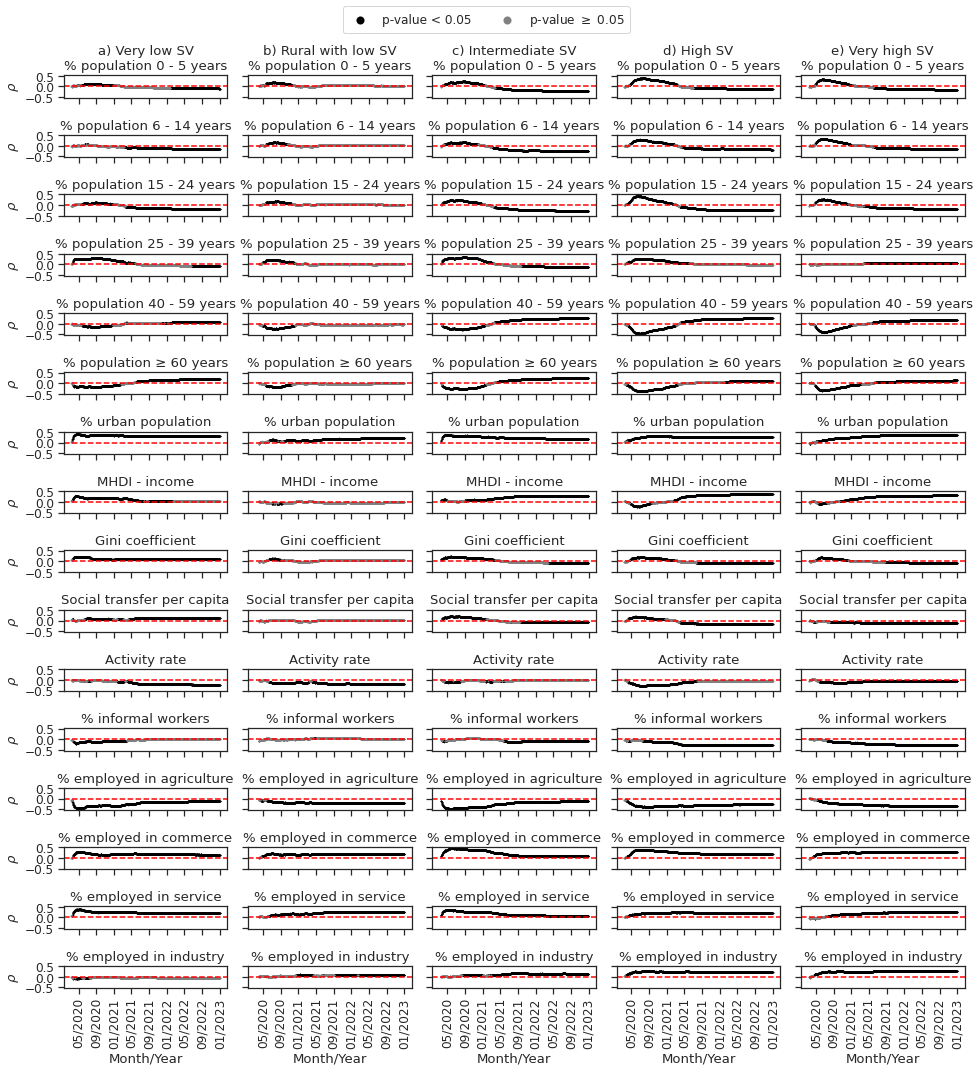

In [61]:
myFmt = mdates.DateFormatter('%m/%Y')
sns.set(font_scale=1.1)
sns.set_style("ticks")
palette = sns.dark_palette("#F2F2F2", reverse=True, as_cmap=True)

fig, ax = plt.subplots(16, 5, figsize=(util.centimeter_to_inch(34.8), util.centimeter_to_inch(37)), sharex=True, sharey=True)

for i, list_df_correlation in enumerate(matriz_df_correlation):
    
    for j, df_temp in enumerate(list_df_correlation):
        chart = sns.scatterplot(data=df_temp[df_temp.pvaule<0.05], x='date', y='correlation', color='black', markers=False, legend=((i==0) & (j==0)), ax=ax[j][i], s=2.5, ec="face", label='p-value < 0.05')
        sns.scatterplot(data=df_temp[df_temp.pvaule>=0.05], x='date', y='correlation', color='gray', markers=False, legend=((i==0) & (j==0)), ax=ax[j][i], s=2.5, ec="face", label='p-value $\geq$ 0.05')
    
        chart = ax[j][i]
        chart.set_ylabel(r"$\rho$")
        if j == 0:
            chart.set_title(grops_id[i] + " " + clusters[i] + "\n" + attribute_names[j])
        else:          
            chart.set_title(attribute_names[j])        
    
        chart.axhline(0, 0, 1, linestyle='--', color='red')
    
        if j == 15:  # Adjust the condition based on the position of the second column
            chart.xaxis.set_major_formatter(myFmt)
            chart.set_xlabel('Month/Year')
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation

legend_kwargs = {'scatterpoints': 1, 'markerscale': 5}  # Adjust markerscale as needed
ax[0][0].legend(**legend_kwargs)  # Pass kwargs for legend

fig.legend(ax[0][0].get_legend().legendHandles,['p-value < 0.05','p-value $\geq$ 0.05'], ncol=2, loc='center', frameon=True, bbox_to_anchor=(0.5, 1.01))
ax[0][0].get_legend().remove()

fig.tight_layout()
plt.savefig('images/timeseries_correlations_deaths_attributes_small_multiples.png', bbox_inches="tight")
plt.savefig('images/timeseries_correlations_deaths_attributes_small_multiples.pdf', bbox_inches="tight")
plt.savefig('images/timeseries_correlations_deaths_attributes_small_multiples.eps', bbox_inches="tight")
plt.show()

## Small multiples for all regions and attributes

In [59]:
regions = ts.REGIAO_EN.unique().tolist()
regions

['Midwestern', 'Southeast', 'Northeast', 'South', 'North']

In [60]:
matriz_df_correlation = []

for cluster in regions:
    list_df_correlation = []
    ts_temp = ts[ts.REGIAO_EN == cluster]
    for attribute in selected_attributes_for_ts_analysis:
        df_correlation = pd.DataFrame()
        for date in df_dates.DATA:
            df_temp = ts_temp[ts_temp.DATA == date]
            correlation, pvalue = spearmanr(df_temp[['TAXA_OBITOS_ACUMULADO', attribute]])
            df_correlation = df_correlation.append(pd.DataFrame({'date': [date], 'correlation': [correlation], 'pvaule': [pvalue]}), ignore_index=True)
        list_df_correlation.append(df_correlation)
    matriz_df_correlation.append(list_df_correlation)

/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<ipython-input-61-19776259eb52>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-19776259eb52>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-19776259eb52>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-19776259eb52>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation
<ipython-input-61-19776259eb52>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

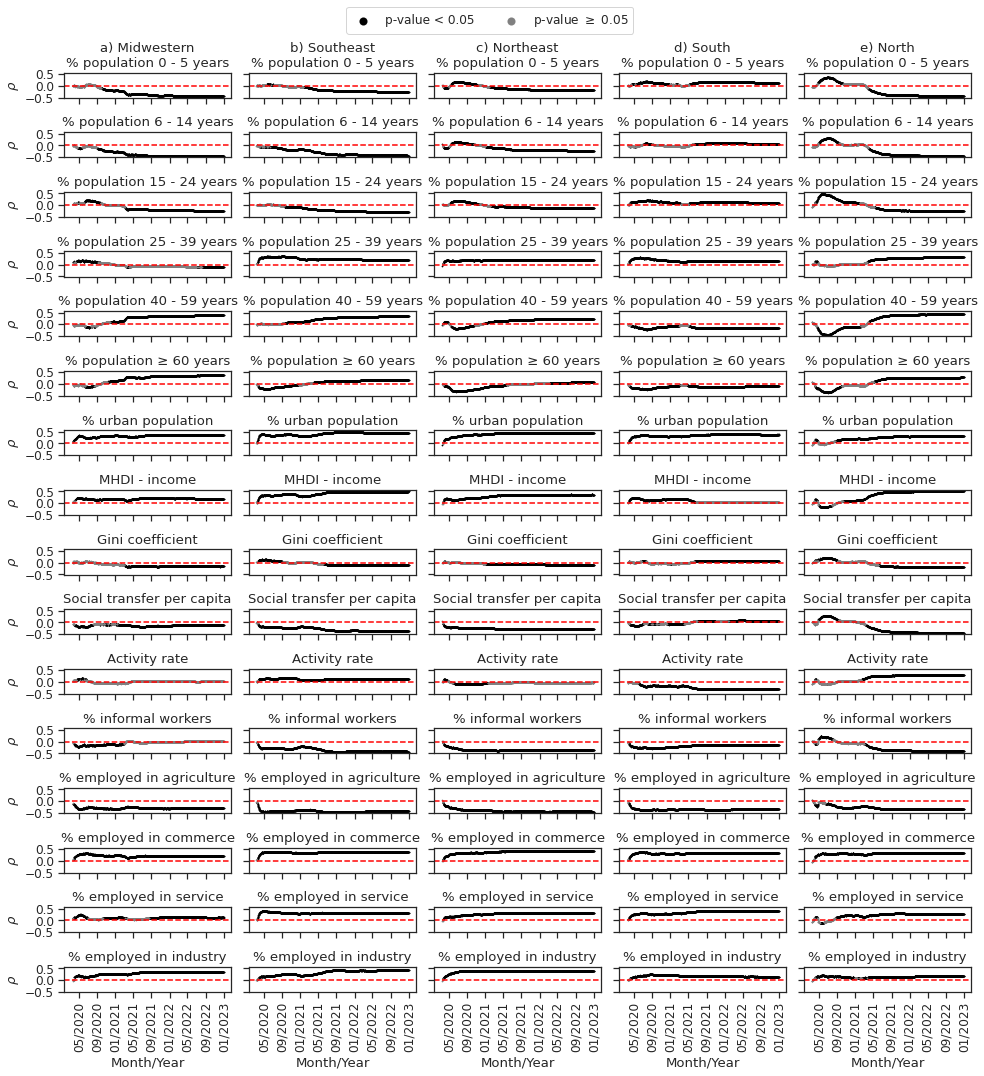

In [61]:
myFmt = mdates.DateFormatter('%m/%Y')
sns.set(font_scale=1.1)
sns.set_style("ticks")
palette = sns.dark_palette("#F2F2F2", reverse=True, as_cmap=True)

fig, ax = plt.subplots(16, 5, figsize=(util.centimeter_to_inch(34.8), util.centimeter_to_inch(37)), sharex=True, sharey=True)

for i, list_df_correlation in enumerate(matriz_df_correlation):
    
    for j, df_temp in enumerate(list_df_correlation):
        chart = sns.scatterplot(data=df_temp[df_temp.pvaule<0.05], x='date', y='correlation', color='black', markers=False, legend=((i==0) & (j==0)), ax=ax[j][i], s=2.5, ec="face", label='p-value < 0.05')
        sns.scatterplot(data=df_temp[df_temp.pvaule>=0.05], x='date', y='correlation', color='gray', markers=False, legend=((i==0) & (j==0)), ax=ax[j][i], s=2.5, ec="face", label='p-value $\geq$ 0.05')
    
        chart = ax[j][i]
        chart.set_ylabel(r"$\rho$")
        if j == 0:
            chart.set_title(grops_id[i] + " " + regions[i] + "\n" + attribute_names[j])
        else:          
            chart.set_title(attribute_names[j])        
    
        chart.axhline(0, 0, 1, linestyle='--', color='red')
    
        if j == 15:  # Adjust the condition based on the position of the second column
            chart.xaxis.set_major_formatter(myFmt)
            chart.set_xlabel('Month/Year')
            chart.set_xticklabels(chart.get_xticklabels(), rotation=90)  # Set x-axis tick label rotation

legend_kwargs = {'scatterpoints': 1, 'markerscale': 5}  # Adjust markerscale as needed
ax[0][0].legend(**legend_kwargs)  # Pass kwargs for legend

fig.legend(ax[0][0].get_legend().legendHandles,['p-value < 0.05','p-value $\geq$ 0.05'], ncol=2, loc='center', frameon=True, bbox_to_anchor=(0.5, 1.01))
ax[0][0].get_legend().remove()

fig.tight_layout()
plt.savefig('images/timeseries_correlations_deaths_attributes_small_multiples_regions.png', bbox_inches="tight")
plt.savefig('images/timeseries_correlations_deaths_attributes_small_multiples_regions.pdf', bbox_inches="tight")
plt.savefig('images/timeseries_correlations_deaths_attributes_small_multiples_regions.eps', bbox_inches="tight")
plt.show()